This notebook demonstrates sampling the stochastic AEM inversions at a number of points and finding the weighted average bulk conductivity for a given depth interval. This depth interval is based x m below the water table, which is defined in a raster file.

In [1]:
%matplotlib inline


In [60]:
import netCDF4
import numpy as np
import pandas as pd
import os
from osgeo import osr, gdal
from shapely.geometry import box, Point, Polygon
# These packages are geoscience australia packages for geophysics and hydrogeological data
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from geophys_utils import points2convex_hull

In [61]:
# Birng the AEM data into memory
cond_path = r"C:\Users\PCUser\Desktop\AEM\rjmcmc\EastKimberley_rjmcmc.nc"

rj_dat = netCDF4.Dataset(cond_path, 'r')

In [62]:
coords = np.column_stack((rj_dat['easting'][:].data,
                         rj_dat['northing'][:].data))

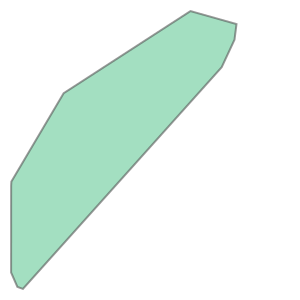

In [63]:
# Create a convex hull around the Keep River area based on line 3xxx,xxx

# Initialise an instance of the netCDF point and line utility classes
cond_line_utils = NetCDFLineUtils(rj_dat)
cond_point_utils = NetCDFPointUtils(rj_dat)

# Get the utm coordinates for the survey

utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

# Get the lines nun,bers in our area of interest

lines = cond_line_utils.line

# Get the index of lines of interest

line_ind  = np.where(np.logical_and(lines>299999, lines<399999))

# Get the indices of points in the rj file from these lines
point_mask = [x for x in rj_dat['line_index'][:] if np.any(line_ind == x)]
    
# Get the Keep River coords    

Keep_river_coords = aem_coords[point_mask]

# We also want to filter out lines that are too far west

Keep_river_coords = Keep_river_coords[np.where(Keep_river_coords[:,0] > 500000)]
    
# Get the convex hull of the subset
convex_hull = points2convex_hull(Keep_river_coords)


# Create a shapely object of the convex hull
Keep_poly = Polygon(convex_hull)


Keep_poly

In [65]:
# Ugly raster sampling


# Open the raster using raster i
infile = "..\\water_table_mAHD.tif"

wt_src = rasterio.open(infile)

# Create a polygon around the extent of raster

wt_poly = box(wt_src.bounds.left, wt_src.bounds.bottom,
              wt_src.bounds.right, wt_src.bounds.top)



# Get indices of rjmcmc coordinates that are within our area of interest

inds = []

for i in range(coords.shape[0]):
    P = Point(coords[i])
    if np.logical_and(P.within(Keep_poly), P.within(wt_poly)):
        inds.append(i)

        
inds = np.array(inds)      

# Extract these coordinates to an array

wt_coords = coords[inds]
        
# Now sample the water table elevation and calculate depth

wt_elevs = np.zeros(shape = wt_coords.shape[0],
                    dtype = np.float64)

# Iterate through rjmcmc coordinates
for i in range(len(wt_coords)):
    #Get elevation using the generator
    wte = next(wt_src.sample(wt_coords[i:i+1]))[0]
    
    # Write into array
    wt_elevs[i] = wte
    

# mask out -9999.

mask = np.isclose(wt_elevs, -9999.)

inds = inds[~mask]

wt_elevs = wt_elevs[~mask]

In [66]:
df_final = pd.DataFrame(columns = ['Depth_from', 'Depth_to', 'easting',
                                  'northing'] + ['cond_' + str(i+1) for i in range(100)])

In [67]:
# Now we have the coordinates we need to extract all the 10m pmaps 

# choose our interval

interval = 10. # We will examine the top 10 metres of the water table

for i, idx in enumerate(inds):
    # Calculate depth
    wt_depth = rj_dat['elevation'][idx] - wt_elevs[i]
    
    # Get the layer to depths 
    
    ltd = rj_dat['layer_top_depth'][idx]
    
    # find the index of the top and bottom of the interval
    top_idx = np.searchsorted(ltd, wt_depth,
                              side = 'right')
    
    bottom_idx  = np.searchsorted(ltd, wt_depth + interval,
                              side = 'right')
    # Get all indices
    layer_idx = np.arange(top_idx, bottom_idx)
    
    # Get the conductivity bins and sum them along the depth axis
    
    cond_bin_counts = rj_dat['conductivity_bin_count'][idx, layer_idx, :].sum(axis = 0)
    
    # Write this into a dataframe
    
    dat = {'Depth_from': ltd[top_idx], 'Depth_to': ltd[bottom_idx], 'easting': rj_dat['easting'][idx],
           "northing": rj_dat['northing'][idx]}
    
    for i in range(len(cond_bin_counts)):
        dat['cond_' + str(i+1)] = cond_bin_counts[i]
    
    # Append dictionary to data frame
        
    df_final = df_final.append(dat, ignore_index = True)
           
    

In [69]:
df_final.to_csv(r"..\\EK_cond_pmap_top10m_saturated_zone.csv",
               index = False)

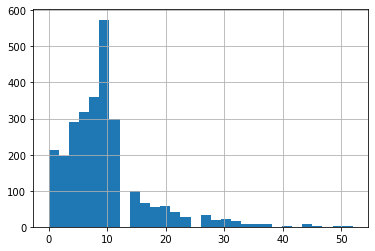

In [70]:
df_final['Depth_from'].hist(bins=30)